In [1]:
# https://blog.socialcops.com/engineering/machine-learning-python/
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 8.0)

# Let's read in the Titanic data for a deeper analysis

In [2]:
data = pd.read_excel('data/titanic3.xls', 'titanic3', index_col=None, na_values=['NA'])

## Legend
* pclass = Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
* survival (0 = No; 1 = Yes)
* sibsp = number of Siblings/Spouses Aboard
* parch = number of Parents/Children Aboard
* ticket = ticket Number
* embarked (from...C = Cherbourg; Q = Queenstown; S = Southampton)
* boat = Lifeboat ID
* body = ID Number
* home.dest = Home/Destination

In [3]:
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


### These columns are unlikely to be meaningful and have several missing values so we'll drop them.

In [4]:
data = data.drop(['boat', 'ticket', 'cabin', 'body'], axis=1)

### We can get a quick summary of how many people survived.

In [5]:
data['survived'].value_counts()

0    809
1    500
Name: survived, dtype: int64

### Because we encode survival as '1', finding the mean will give us a survival percentage. Why?

In [6]:
data['survived'].mean()

0.3819709702062643

### If we group by class and then compute the mean, what does this reveal?

In [7]:
data.groupby('pclass').mean()

,survived,age,sibsp,parch,fare
pclass,,,,,
1,0.619195,39.159918,0.436533,0.365325,87.508992
2,0.429603,29.506705,0.393502,0.368231,21.179196
3,0.255289,24.816367,0.568406,0.400564,13.302889


### If we group by class and gender and compute the mean, what does this tell us about the "Women" part of "Women and children first?"

In [8]:
class_gender_grouping = data.groupby(['pclass', 'sex']).mean()
class_gender_grouping

survived        age     sibsp     parch        fare
pclass sex                                                        
1      female  0.965278  37.037594  0.555556  0.472222  109.412385
       male    0.340782  41.029250  0.340782  0.279330   69.888385
2      female  0.886792  27.499191  0.500000  0.650943   23.234827
       male    0.146199  30.815401  0.327485  0.192982   19.904946
3      female  0.490741  22.185307  0.791667  0.731481   15.324250
       male    0.152130  25.962273  0.470588  0.255578   12.415462

### Let's render it as a bar chart to make it clear...

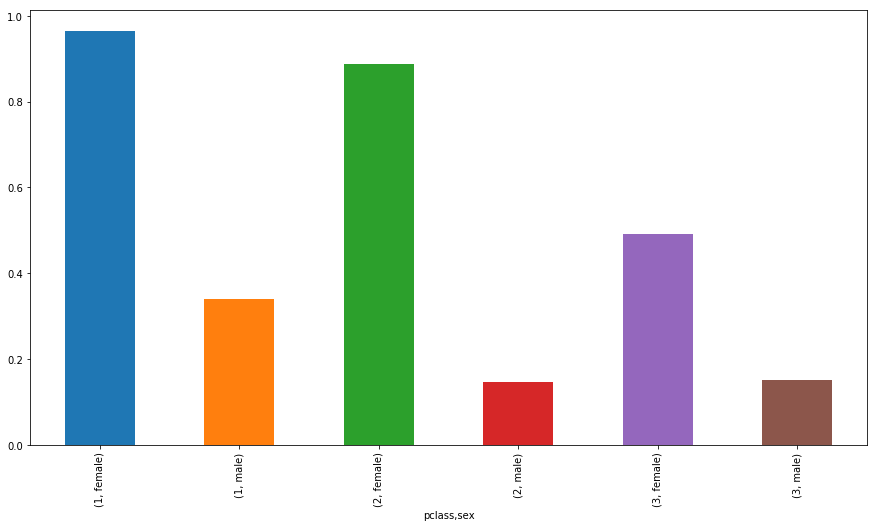

In [9]:
class_gender_grouping['survived'].plot.bar();

### If we investigate the passengers by age, we can investigate the "Children" part of "Women and children first".

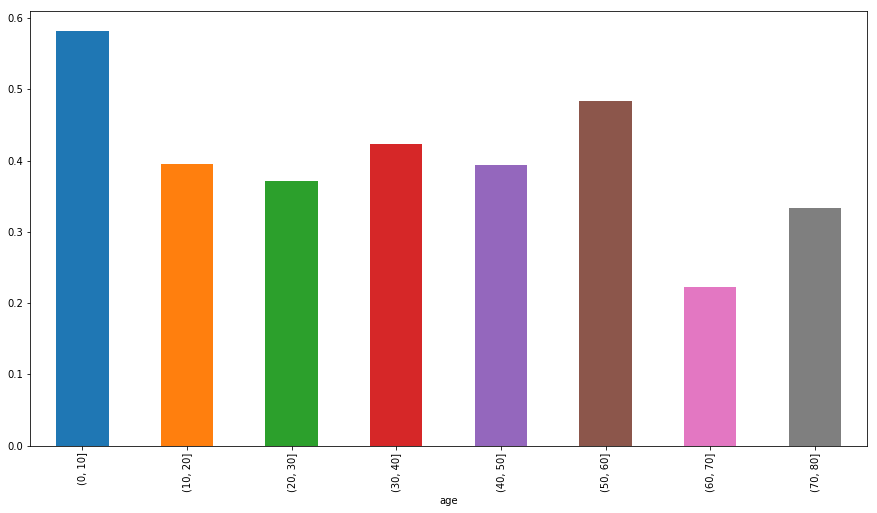

In [10]:
group_by_age = pd.cut(data["age"], np.arange(0, 90, 10))
age_grouping = data.groupby(group_by_age).mean()
age_grouping['survived'].plot.bar();

### We have a fair amount of missing values (e.g., age, home.dest)

In [12]:
data.count()

pclass       1309
survived     1309
name         1309
sex          1309
age          1046
sibsp        1309
parch        1309
fare         1308
embarked     1307
home.dest     745
dtype: int64

### We can fill in the missing age values with average values. Is this a good strategy for this data? What could we exploit to make a better go of it? (Hint: Look at the class breakdowns above)

In [13]:
data = data.fillna(data.mean())

### Now we are basically missing home/destination data and a few embarked results.

In [14]:
data.count()

pclass       1309
survived     1309
name         1309
sex          1309
age          1309
sibsp        1309
parch        1309
fare         1309
embarked     1307
home.dest     745
dtype: int64

### With only two results missing embarked data, we can probably just drop those samples.

In [15]:
data[data['embarked'].isnull()]

,pclass,survived,name,sex,age,sibsp,parch,fare,embarked,home.dest
168,1,1,"Icard, Miss. Amelie",female,38.0,0,0,80.0,NaN,NaN
284,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,80.0,NaN,"Cincinatti, OH"


### There are a substantial number of missing home/destination values. We don't know if that is an important feature, but we'd lose a lot of data if we throw those samples away, so let's fill it in with placeholders for now.

In [16]:
data["home.dest"] = data["home.dest"].fillna("NA")

### Now with only the two embarked rows missing, we are in good shape, so let's drop those and then move on.

In [17]:
data.count()

pclass       1309
survived     1309
name         1309
sex          1309
age          1309
sibsp        1309
parch        1309
fare         1309
embarked     1307
home.dest    1309
dtype: int64

In [18]:
data = data.dropna()

In [19]:
data.count()

pclass       1307
survived     1307
name         1307
sex          1307
age          1307
sibsp        1307
parch        1307
fare         1307
embarked     1307
home.dest    1307
dtype: int64

### We are going to turn categorical data (__`sex`__ and __`embarked`__) into numbered values using a Sci-Kit Learn __`LabelEncoder`__.

In [20]:
from sklearn import datasets, svm, cross_validation, tree, preprocessing, metrics
import sklearn.ensemble as ske

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [21]:
def preprocess_titanic_df(df):
    processed_df = df.copy()
    le = preprocessing.LabelEncoder()
    
    processed_df.sex = le.fit_transform(processed_df.sex)
    processed_df.embarked = le.fit_transform(processed_df.embarked)
    processed_df = processed_df.drop(['name','home.dest'],axis=1)
    
    return processed_df

### We preprocess our data and then verify that everything is suitable for a learning activity now.

In [22]:
processed_df = preprocess_titanic_df(data)
processed_df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1,1,0,29.0000,0,0,211.3375,2
1,1,1,1,0.9167,1,2,151.5500,2
2,1,0,0,2.0000,1,2,151.5500,2
3,1,0,1,30.0000,1,2,151.5500,2
4,1,0,0,25.0000,1,2,151.5500,2


### The survival data is going to be our target so we drop it from the feature matrix and set up the target matrix.

In [23]:
X = processed_df.drop(['survived'], axis=1).values
y = processed_df['survived'].values

### We now split our data into training and test data, create a DecisionTreeClassifier and then see how we do on predictions on survival.

In [24]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

In [25]:
clf_dt = tree.DecisionTreeClassifier(max_depth=3)

In [26]:
clf_dt.fit(X_train, y_train)
clf_dt.score(X_test, y_test)

0.7786259541984732

In [27]:
y

array([1, 1, 0, ..., 0, 0, 0])

In [28]:
from sklearn.tree import export_graphviz
export_graphviz(clf_dt, out_file="titanic.dot",
               feature_names='pclass sex age sibsp parch fare embarked'.split(),
               class_names='died survived'.split(),
               rounded=True,filled=True)

In [29]:
!dot -Tpng titanic.dot -o titanic.png
!open titanic.png

### Shuffling the data can sometimes improve our results.

In [ ]:
shuffle_validator = cross_validation.ShuffleSplit(len(X), n_iter=20, test_size=0.2, random_state=0)
def test_classifier(clf):
    scores = cross_validation.cross_val_score(clf, X, y, cv=shuffle_validator)
    print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std()))

In [ ]:
test_classifier(clf_dt)

### A RandomForestClassifier often does better.

In [ ]:
clf_rf = ske.RandomForestClassifier(n_estimators=50)
test_classifier(clf_rf)

### Other classifiers might do even better...

In [ ]:
clf_gb = ske.GradientBoostingClassifier(n_estimators=50)
test_classifier(clf_gb)

### Now we want to make a specific point, so we'll grab the first twenty rows of each passenger class from our raw data, clean them up and  use them to test the model.

In [ ]:
passengers_set_1 = data[data.pclass == 1].iloc[:20,:].copy()
passengers_set_2 = data[data.pclass == 2].iloc[:20,:].copy()
passengers_set_3 = data[data.pclass == 3].iloc[:20,:].copy()
passenger_set = pd.concat([passengers_set_1, passengers_set_2, passengers_set_3])
testing_set = preprocess_titanic_df(passenger_set)

### Normally you wouldn't train and test on the same data, but we are making a specific point here.

In [ ]:
training_set = pd.concat([data, passenger_set]).drop_duplicates(keep=False)
training_set = preprocess_titanic_df(training_set)

In [ ]:
X = training_set.drop(['survived'], axis=1).values
y = training_set['survived'].values
X_test = testing_set.drop(['survived'], axis=1).values
y_test = testing_set['survived'].values

In [ ]:
clf_rf = ske.RandomForestClassifier(n_estimators=50)
clf_rf.fit(X, y)

In [ ]:
prediction = clf_rf.predict(X_test)

### Because this is historical data, we can compare predictions to what actually happened. Models are not destiny and some of the people our model thought would survive didn't and some of the people it thought wouldn't did. (e.g. Mrs. Allison Hudson (Bessie) and Mr. Olaus Abelseth).

In [ ]:
passenger_set[passenger_set.survived != prediction]

In [ ]:
passenger_set[passenger_set['name'].str.contains("Allison")]